# Содержание

[Постановка задачи](#Постановка-задачи)<br>
<br>[0. Загрузка библиотек](#0.-Загрузка-библиотек)<br>
<br>[1. Загрузка и подготовка данных](#1.-Загрузка-и-подготовка-данных)<br>
[1.1 Обзор данных](#1.1-Обзор-данных)<br>
[1.2 Описание количественных признаков](#1.2-Описание-количественных-признаков)<br>
[1.3 Описание категориальных признаков](#1.3-Описание-категориальных-признаков)<br>
<br>[2. Исследование зависимостей и формулирование гипотез](#2.-Исследование-зависимостей-и-формулирование-гипотез)<br>
[2.1 Разведочный анализ данных](#2.1-Разведочный-анализ-данных)<br>
[2.2 Формулирование гипотез](#2.2-Формулирование-гипотез)<br>
<br>[3. Построение ML моделей](#3.-Построение-ML-моделей)<br>
[3.1 SVM](#3.1-SVM)<br>
[3.1.1 Без оверсемплинга классов](#3.1.1-Без-оверсемплинга-классов)<br>
[3.1.2 Без оверсемплинга классов с учетом весов](#3.1.2-Без-оверсемплинга-классов-с-учетом-весов )<br>
[3.1.3 С оверсемплингом классов](#3.1.3-С-оверсемплингом-классов)<br>
[3.2 RandomForestClassifier](#3.2-RandomForestClassifier)<br>
[3.2.1 Без оверсемплинга классов](#3.2.1-Без-оверсемплинга-классов)<br>
[3.2.2 Без оверсемплинга классов с учетом весов](#3.2.2-Без-оверсемплинга-классов-с-учетом-весов )<br>
[3.2.3 С оверсемплингом классов](#3.2.3-С-оверсемплингом-классов)<br>
[3.3 LGBMClassifier](#3.3-LGBMClassifier)<br>
[3.3.1 Без оверсемплинга классов](#3.3.1-Без-оверсемплинга-классов)<br>
[3.3.2 Без оверсемплинга классов с учетом весов](#3.3.2-Без-оверсемплинга-классов-с-учетом-весов )<br>
[3.3.3 С оверсемплингом классов](#3.3.3-С-оверсемплингом-классов)<br>
<br>[4. Сравнение качества ML моделей](#4.-Сравнение-качества-ML-моделей)<br>
<br>[5. Построение DL моделей](#5.-Построение-DL-моделей)<br>
<br>[Oбщие выводы работы](#Oбщие-выводы-работы)<br>

## Постановка задачи
**Высокоэнтропийные сплавы (ВЭС)** являются особым типом металлических сплавов, которые представляют огромный интерес как перспективные материалы благодаря их высокой твердости, износостойкости, стойкости к высокотемпературному размягчению и окислению. **ВЭС** обычно состоят из более чем пяти металлических элементов в равных или почти равных атомных соотношениях. Важной особенностью таких металлических систем является то, что они имеют тенденцию образовывать структуру твердого раствора (в основном **ГЦК** и / или **ОЦК**), а не несколько интерметаллических соединений, как ожидается из общих физических принципов металлургии. Понимание особеностей фазообразования в ВЭС имеет большое значение при разработке новых сплавов. К настоящему времени известно, что к числу наиболее важных факторов, влияющих на структурно-фазовый состав ВЭС, относятся **энтальпия смешения (dHmix)**, **энтропия смешения (dSmix)**, **разница в размерах атомов ($\delta$)** и **концентрация валентных электронов (VEC)**.

**Цель:** Построить модель машинного обучения, которая позволит предсказать фазовый состав высокоэнтропийного сплава.

## 0. Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, recall_score

from sklearn.metrics import log_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import joblib

import os

import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from livelossplot.tf_keras import PlotLossesCallback

import shap

In [2]:
# настройка вывода графики
params = {
    'axes.titlesize': '16',
    'axes.labelsize': '14',
    'xtick.labelsize': '14',
    'ytick.labelsize': '14',
    'legend.title_fontsize': '14',
    'legend.fontsize': '12'
}

pylab.rcParams.update(params)

## 1. Загрузка и подготовка данных

### 1.1 Обзор данных

In [3]:
# загрузка csv файла
df_HEA = pd.read_csv('HEA_dataset.csv', encoding='utf-8')

pd.set_option('display.max_columns', 53)
df_HEA.head()

Alloy  Num_of_Elem  Density_calc  dHmix  dSmix       Tm  Omega  \
0  Ag1Au1            2         14.88   -6.0   5.76  1286.13   1.24   
1  Co1Fe1            2          8.37   -1.0   5.76  1789.50  10.31   
2  Co1Ni1            2          8.90    0.0   5.76  1748.00    inf   
3  Cu1Ni1            2          8.91    4.0   5.76  1542.88   2.22   
4  Fe1Ni1            2          8.37   -2.0   5.76  1769.50   5.10   

   Atom.Size.Diff  Elect.Diff   VEC           phi   RMS   dHim  k_cr   eta  \
0            0.35        0.31  11.0  3.146300e+02  0.35  1.370  1.27  0.50   
1            0.79        0.03   8.5  2.837100e+02  0.79  5.790  3.27  0.98   
2            0.00        0.02   9.5  5.200000e+14  0.00    inf   inf  2.73   
3            1.19        0.01  10.5  7.744000e+01  1.19 -0.145  1.49  8.45   
4            0.79        0.04   9.0  2.525500e+02  0.79  4.680  2.12  0.60   

   E2_E0 lattice  
0   0.06     FCC  
1   0.31     FCC  
2   0.00     FCC  
3   0.70     FCC  
4   0.31     FCC

**В датасете представлены следующие поля:**
- *Alloy*: сплав
- *Num_of_Elem*: количество элементов
- *Density_calc*: плотность по правилу смесей
- *dHmix*: энтальпия смешения
- *dSmix*: энтропия смешения
- *Tm*: температура плавления по правилу смесей
- *Omega*: параметр $\Omega = \frac{T_m\Delta S_{conf}}{\Delta H_{mix}}$
- *Atom.Size.Diff*: различие размеров атомов
- *Elect.Diff*: различие электроотрицательностей
- *VEC*: концентрация валентных электронов
- *phi*: параметр $\phi = \frac{k_B\Delta S_{conf} - |\Delta H_{mix}|/ T_m}{|\Delta S_{E}|}$
- *RMS*: среднеквадратичное значение упругой остаточной деформации
- *dHim*: средневзвешенная энтальпии образования наиболее стабильных составляющих бинарных интерметаллических соединений
- *k_cr*: параметр $k_{cr} = 1 + \frac{T_{ann}\Delta S_{conf}}{|\Delta H_{mix}|}(1 - k)$
- *eta*: параметр $\eta = \frac{T_{ann}\Delta S_{conf}}{|\Delta H_{im}|}$
- *E2_E0*: внутренняя энергия деформации
- *lattice*: целевой признак экспериментально наблюдаемых структурно-фазовых состояний (**BCC** - ОЦК фаза, **FCC** - ГЦК фаза, **HCP** - ГПУ фаза, **multi-phase** - многофазные твердые растворы и интерметаллиды и **amorphous** - аморфные фазы)

Для дальнейшего анализа элементный состав и такие расчетные параметры, как 'Omega', 'phi', 'k_cr' и'eta', которые зависят от эмперических термодинамических величин, не представляют большого интереса, в дальнейшем эти признаки не будут рассматриваться.

In [4]:
# удаление параметров и признаков, связанных с элементным составом
df_HEA.drop(columns=['Alloy' ,'Omega', 'phi', 'k_cr', 'eta', 'dHim'], inplace=True)

df_HEA.head()

Num_of_Elem  Density_calc  dHmix  dSmix       Tm  Atom.Size.Diff  \
0            2         14.88   -6.0   5.76  1286.13            0.35   
1            2          8.37   -1.0   5.76  1789.50            0.79   
2            2          8.90    0.0   5.76  1748.00            0.00   
3            2          8.91    4.0   5.76  1542.88            1.19   
4            2          8.37   -2.0   5.76  1769.50            0.79   

   Elect.Diff   VEC   RMS  E2_E0 lattice  
0        0.31  11.0  0.35   0.06     FCC  
1        0.03   8.5  0.79   0.31     FCC  
2        0.02   9.5  0.00   0.00     FCC  
3        0.01  10.5  1.19   0.70     FCC  
4        0.04   9.0  0.79   0.31     FCC

Следующая группа признаков, которую следует удалить из рассмотрения, связана с деформационными характеристиками высокоэнтропийных сплавов. В исследуемом датасете к таким признакам относятся величины среднеквадратичной упругой остаточной деформации 'RMS' и внутренняя энергия деформации 'E2_E0'. Несмотря на то, что особенности деформационного поведения во многом определяют особенности структурно-фазовых трансформаций, к сожалению, на данном этапе исследования наличие только двух указанных выше признаков ме позволяют выявить прямую связь между механическими свойствами и фазовым составом высокоэнтропийной металлической системы. Кроме этого, признак 'RMS' в значительной степени определяется атомными размерами компонент и практически коллениарен признаку Atom.Size.Diff.

In [5]:
# удаление признаков, связанных с деформацией
df_HEA.drop(columns=['RMS', 'E2_E0'], inplace=True)

df_HEA.head()

Num_of_Elem  Density_calc  dHmix  dSmix       Tm  Atom.Size.Diff  \
0            2         14.88   -6.0   5.76  1286.13            0.35   
1            2          8.37   -1.0   5.76  1789.50            0.79   
2            2          8.90    0.0   5.76  1748.00            0.00   
3            2          8.91    4.0   5.76  1542.88            1.19   
4            2          8.37   -2.0   5.76  1769.50            0.79   

   Elect.Diff   VEC lattice  
0        0.31  11.0     FCC  
1        0.03   8.5     FCC  
2        0.02   9.5     FCC  
3        0.01  10.5     FCC  
4        0.04   9.0     FCC

In [6]:
# количество уникальных значений по столбцам
for col in df_HEA.columns:
        print(f'COLUMN NAME: {col}\nVALUE:\n{df_HEA[col].value_counts()}', 
              end='\n' + '-'*50 + '\n')

COLUMN NAME: Num_of_Elem
VALUE:
5    152
6    103
7     41
4     28
2     22
3      4
8      3
9      2
Name: Num_of_Elem, dtype: int64
--------------------------------------------------
COLUMN NAME: Density_calc
VALUE:
6.92    5
7.27    5
8.06    5
6.26    4
6.77    4
       ..
7.23    1
5.98    1
5.30    1
5.15    1
5.99    1
Name: Density_calc, Length: 249, dtype: int64
--------------------------------------------------
COLUMN NAME: dHmix
VALUE:
 0.00     11
-1.00      5
-4.00      4
-4.64      3
-4.07      3
          ..
-16.32     1
-2.88      1
-9.28      1
-2.24      1
-31.51     1
Name: dHmix, Length: 301, dtype: int64
--------------------------------------------------
COLUMN NAME: dSmix
VALUE:
13.38    55
5.76     22
11.53    16
14.90    16
14.53    15
         ..
14.78     1
14.61     1
14.01     1
14.21     1
10.18     1
Name: dSmix, Length: 140, dtype: int64
--------------------------------------------------
COLUMN NAME: Tm
VALUE:
1723.60    2
1796.89    2
1630.29    2
2236

Проверка на дубликаты.

In [7]:
# количество дубликатов
df_HEA.duplicated().sum()

0

In [8]:
df_HEA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Num_of_Elem     355 non-null    int64  
 1   Density_calc    355 non-null    float64
 2   dHmix           355 non-null    float64
 3   dSmix           355 non-null    float64
 4   Tm              355 non-null    float64
 5   Atom.Size.Diff  355 non-null    float64
 6   Elect.Diff      355 non-null    float64
 7   VEC             355 non-null    float64
 8   lattice         355 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 25.1+ KB


In [9]:
# реиндексация
df_HEA.reset_index(inplace=True, drop=True)
df_HEA.index

RangeIndex(start=0, stop=355, step=1)

### 1.2 Описание количественных признаков

In [10]:
# информационная сводка по базовым статистикам
df_HEA.describe().T

count         mean         std     min       25%      50%  \
Num_of_Elem     355.0     5.281690    1.234887    2.00     5.000     5.00   
Density_calc    355.0     7.521070    2.350519    2.67     6.410     7.11   
dHmix           355.0   -11.631733   10.206496  -47.59   -16.290    -9.96   
dSmix           355.0    12.807887    2.579563    5.76    11.705    13.38   
Tm              355.0  1830.345408  440.462549  701.58  1640.650  1769.55   
Atom.Size.Diff  355.0     6.123324    4.141484    0.00     3.820     5.28   
Elect.Diff      355.0     0.166076    0.081918    0.00     0.120     0.14   
VEC             355.0     6.631775    1.508680    2.80     5.250     7.06   

                     75%       max  
Num_of_Elem        6.000     9.000  
Density_calc       8.010    21.790  
dHmix             -4.210     4.690  
dSmix             14.530    18.270  
Tm              1912.185  3382.500  
Atom.Size.Diff     6.530    18.370  
Elect.Diff         0.211     0.433  
VEC                7.790    11.000

In [11]:
def num_feat_plot(df: 'pandas.DataFrame', nrows: int, ncols: int, 
                  figsize: tuple[int, int], bins: int, hue: object=None) -> None:
    
    '''Отрисовка гистограммы и плотности распределения значений численных признаков
    
    Args:
        df (pandas.DataFrame): Датафрейм
        nrows (int): Число строк
        ncols (int): Число столбцов
        figsize (tuple[float, float]): Кортеж размера изображений
        bins (int): Число блоков гистограммы
        hue (object): Группирующая переменная
            (default is None)
    Returns:
        None
    '''
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    num_feat_lst = list(df.select_dtypes(exclude=['object']).columns)
    for ax, feat in zip(ax.ravel(), num_feat_lst):
        ax.set_title(f'Гистограмма распределения признака {feat}')
        sns.histplot(data=df, x=feat, bins=bins, hue=hue, kde=True, ax=ax)       
    
    plt.show()

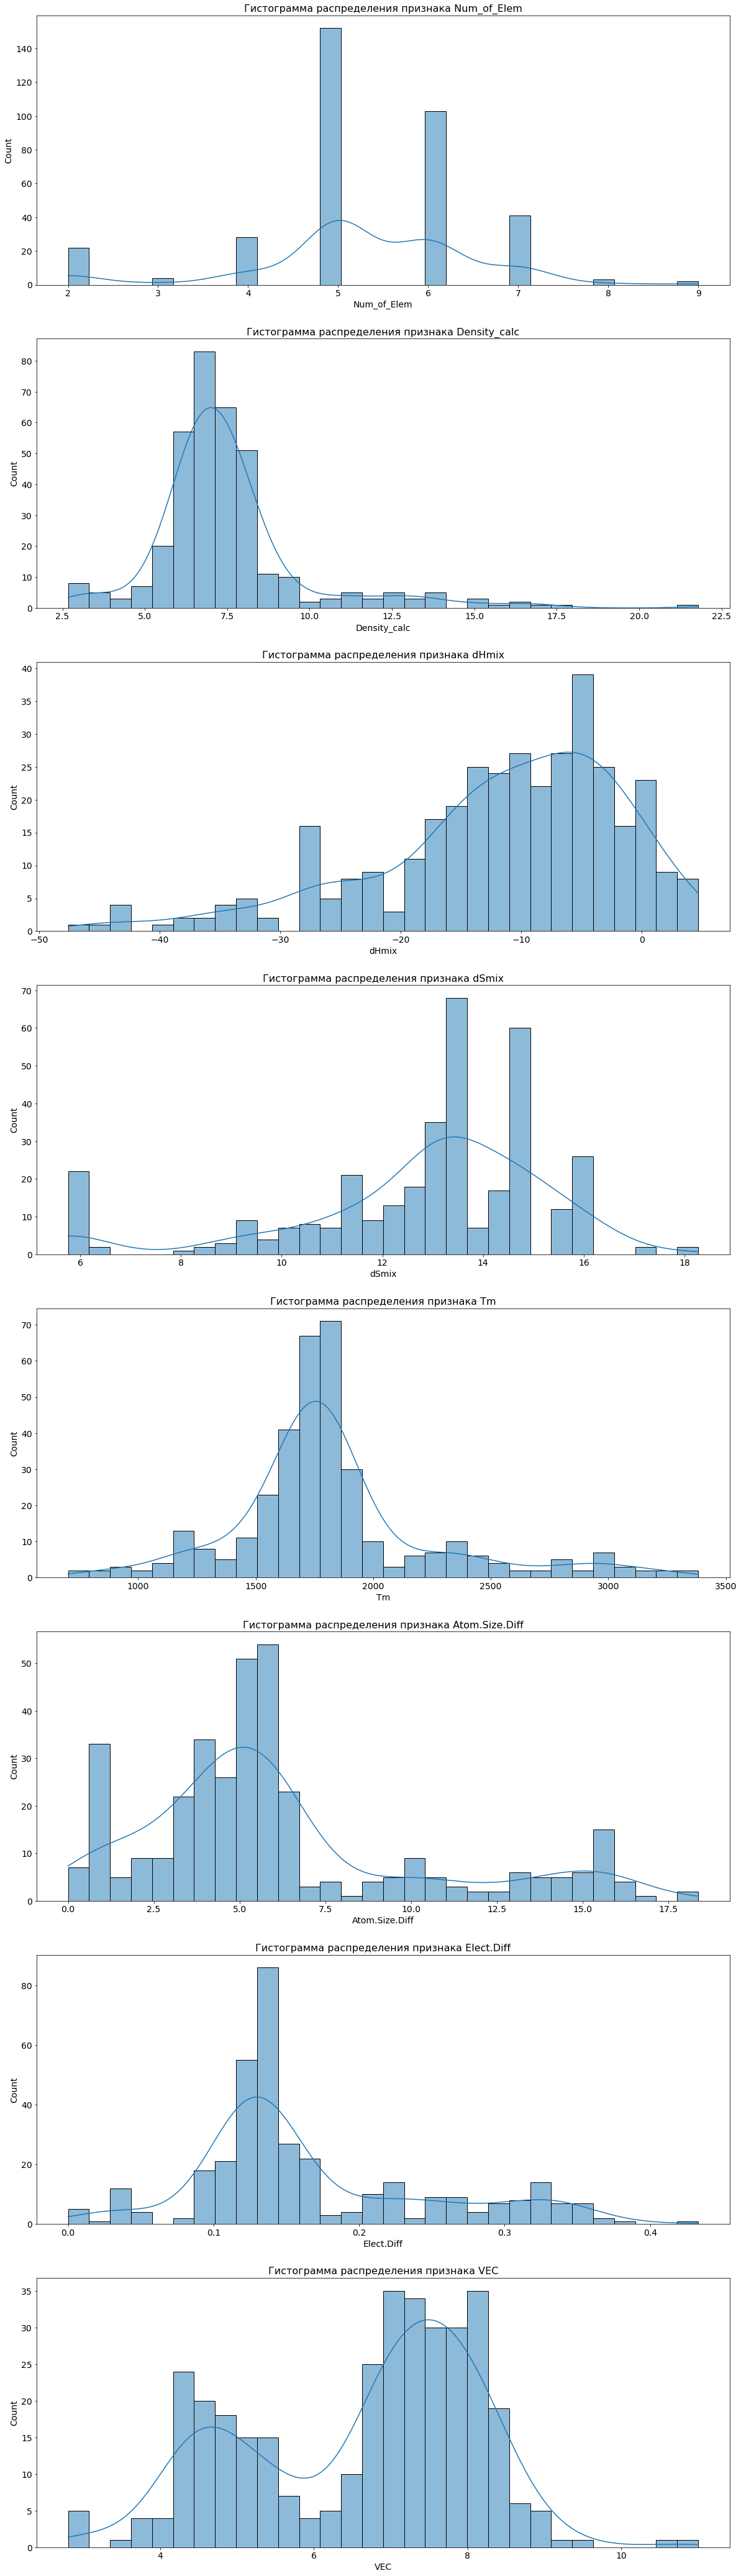

In [12]:
num_feat_plot(df=df_HEA, nrows=8, ncols=1, figsize=(20, 75), bins=30)

На основе анализа гистограмм и плотностей распределения количественных признаков можно выделить следующие особенности.
- На всех гистограмах ярко выраженных аномальных значений или выбросов не наблюдается.
- По числу элементов 5-ти компонентные системы самая многочисленная группа, самая малочисленная - 9-ти компонентные.
- Для признака 'Atom.Size.Diff' имеется максимум, который смещен в область малой разницы атомных размеров. Наличие этой ожидаемой моды можно объяснить так - в случае небольшой разницы атомных размеров, энтропия смешения имеет высокие величины, что способствует формированию высокоэнтропийных сплавов.
- Гистограмма признака 'Density_calc' также представляет собой унимодальное распределение, которое соответсвует средневзвешенному значению плотностей сплавов. Как видно максимум лежит в области средних значений, что свидетельствует об относительно небольшом числе «легких» сплавов (на основе Al, Mg, Be, Ti, Si) и сплавов на основе тугоплавких металлов (Nb, V, Mo, Ta, W, Re, Ru).
- Для признаков, описывающих термодинамические потенциалы и концентрацию валентных электронов, гистограммы мультимодальны. Это обстоятельство во многом связано с физическими особенностями различных фаз, например, на гистограмме признака 'VEC' выделяется две области: при $VEC<6$ область характерна для чистой ОЦК фазы, при $VEC\geq6$ чистой ГЦК и комбинаций ГЦК и ОЦК фаз.

### 1.3 Описание категориальных признаков

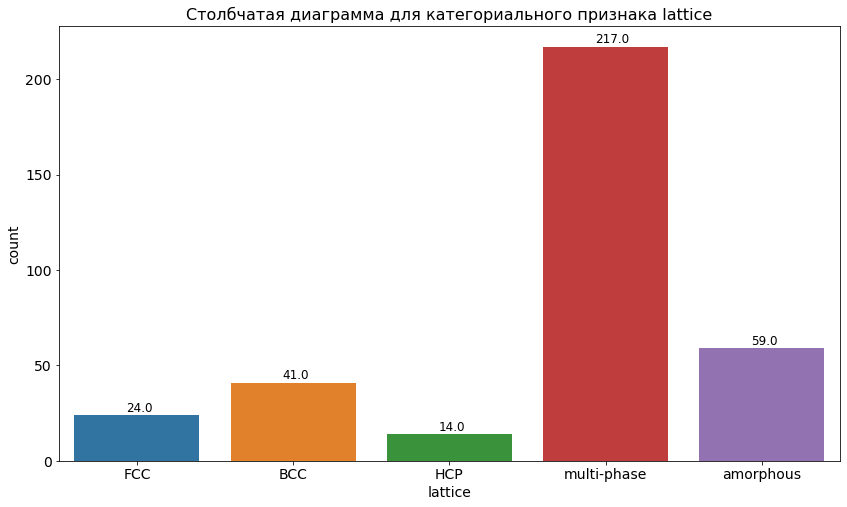

In [13]:
fig, ax = plt.subplots(figsize=(14, 8))
     
sns.countplot(data=df_HEA, x='lattice', ax=ax)

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), 
                (p.get_x() + 0.33, p.get_height() + 2), fontsize=12)

ax.set_title('Столбчатая диаграмма для категориального признака lattice')

plt.show()

На основе анализа столбчатых диаграмм категориального признака можно выделить следующие особенности.
- Целевой класс несбалансирован, этот факт следует учитывать при обучении моделей.
- Самой многочисленной группой является группа многофазных высокоэнтропийных сплавов. Среди чистых фаз более распространена ОЦК фаза. Для представленных в датафрейме сплавов наблюдается относительно большое число материалов с аморфной структурой.

## 2. Исследование зависимостей и формулирование гипотез

### 2.1 Разведочный анализ данных

No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


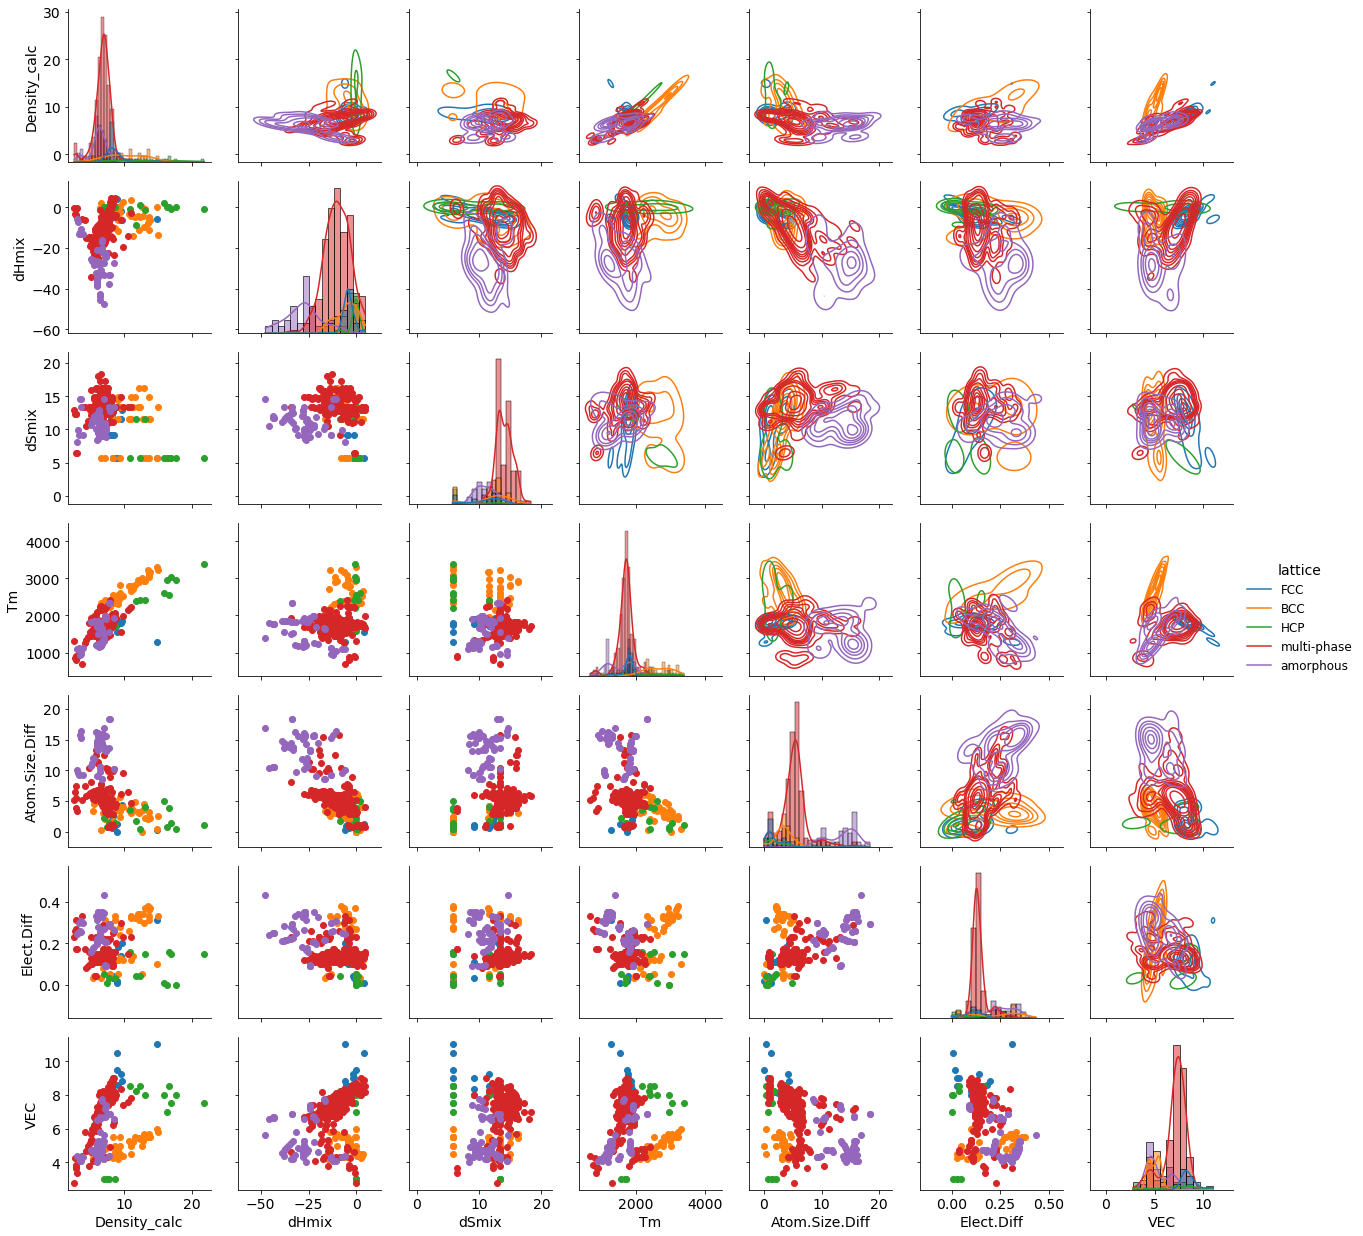

In [14]:
# обзор попарных отношений в данных
g = sns.PairGrid(df_HEA.iloc[:, 1:], hue='lattice', diag_sharey=False)
g.map_lower(plt.scatter)
g.map_upper(sns.kdeplot)
g.map_diag(sns.histplot, kde=True)
g.add_legend()
plt.show()

При первичном анализе попарных отношений в данных относительно наблюдаемых фаз выделяется следующее:
- имеется существенная положительная корреляционная связь между признаками 'Density_calc'-'Tm' и отрицательная между 'Atom.Size.Diff'-'dHmix';
- наилучшее разделение фаз (как минимум фазы BCC_SS) наблюдается относительно признака концентрации валентных электронов 'VEC';
- зачастую сплавы со структурой multi-phase локализованы рядом со сплавами с фазой FCC;
- при парном анализе признаков 'dSmix' и 'dHmix' последний при определении фазового состава выглядит несколько лучше, а в парах 'Elect.Diff' и 'Atom.Size.Diff' - признак 'Elect.Diff'.

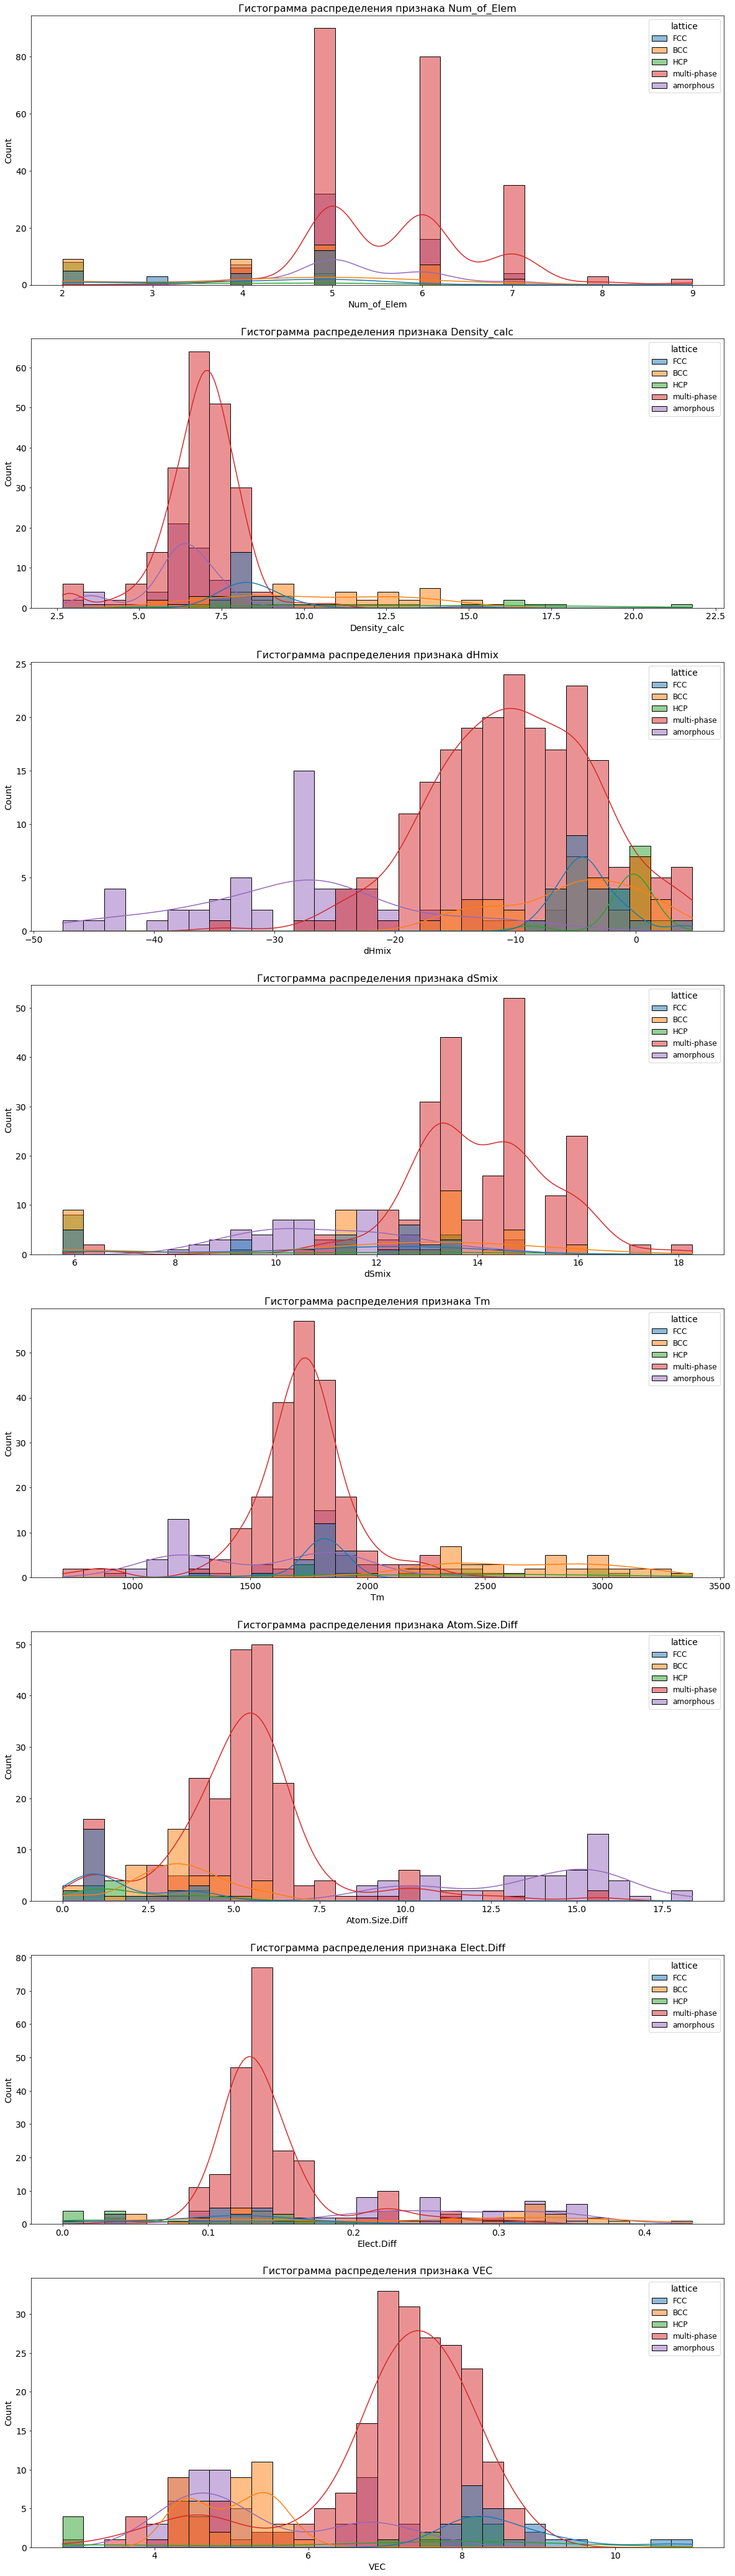

In [15]:
num_feat_plot(df=df_HEA, nrows=8, ncols=1, figsize=(20, 75), bins=30, hue='lattice')

- В большинстве групп сплавов по количеству компонент преобладают фазы **BCC** и **amorphous**, в тоже время имеет место значительное уменьшение доли фаз **FCC** и **HCP** в группах от 6-ти компонентов и выше.
- Согласно плотностям распределений признак 'VEC' действительно хорошо отделяет **BCC_SS** и **FCC_SS** фазы.
- Наихудшее разделение наблюдается у признаков 'Atom.Size.Diff' и 'Elect.Diff'.

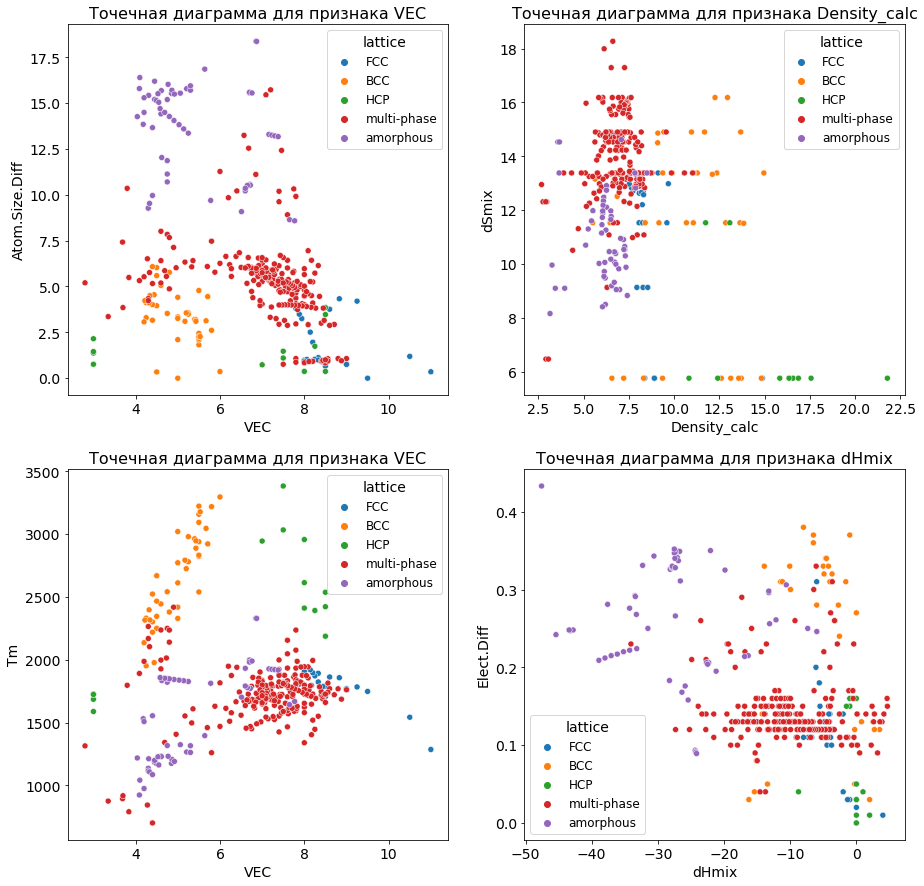

In [16]:
# точечные диаграммы наиболее "интересных" пар признаков 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

x_feat = ['VEC', 'Density_calc', 'VEC', 'dHmix']
y_feat = ['Atom.Size.Diff', 'dSmix', 'Tm', 'Elect.Diff']

for ax, feat in zip(ax.flatten(), zip(x_feat, y_feat)):
    sns.scatterplot(data=df_HEA, x=feat[0], y=feat[1], hue='lattice', ax=ax)
    ax.set_title(f'Точечная диаграмма для признака {feat[0]}')

plt.show()

Более стабильным фазам присущи: 
- небольшие абсолютные значения 'dHmix' и 'Elect.Diff'
- относительно высокие значения VEC ($VEC\geq6$)

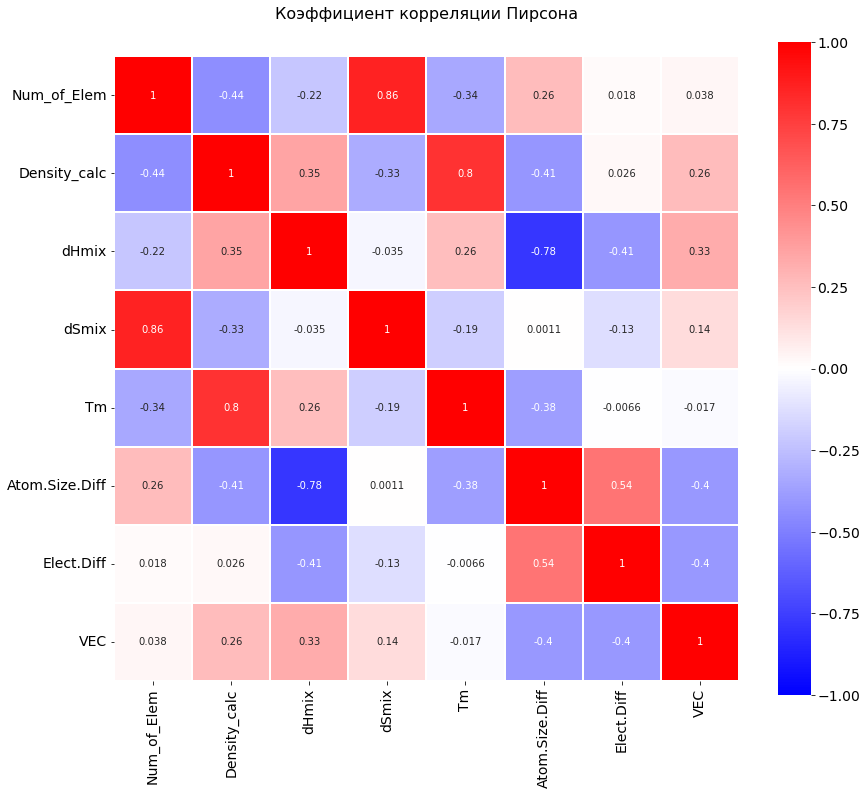

In [17]:
plt.figure(figsize=(14, 12))

colormap = plt.cm.bwr
sns.heatmap(df_HEA.select_dtypes(exclude=['object']).corr(), 
            linewidths=0.1, vmin=-1.0, vmax=1.0, square=True, cmap=colormap, 
            linecolor='white', annot=True)

plt.title('Коэффициент корреляции Пирсона', y=1.05)

plt.show()

- Подтверждается положительная корреляция между признаками 'Density_calc' и 'Tm', а также отрицательная между 'Atom.Size.Diff' и 'dHmix'
- Несмотря на очевидную весьма сильную корреляционную связь между признаками 'dSmix' и 'Num_of_Elem', явной мультиколлинеарности между ними нет, поэтому можно оставить оба признака.

### 2.2 Формулирование гипотез

Согласно проведенному анализу можно выделить два основных фактора, которые определяют структурно-фазовые состояния высокоэнтропийных сплавов:
- среди таких параметров как плотность 'Density_calc', разница в электроотрицательности 'Elect.Diff' и разница в размерах атомов 'Atom.Size.Diff' наиболее важным является концентрация валентных электронов 'VEC';
- на склонность к образованию и устойчивость фаз величина энтальпии смешения 'dHmix' влияет сильнее чем энтропийный член 'dSmix'.

## 3. Построение ML моделей

- В качестве моделей машинного обучения были выбраны метод опорных векторов (SVM) и амблевые методы (RandomForestClassifier, XGBClassifier, LGBMClassifier).
- Так как настоящая задача относится к классу задач мультиклассовой классификации в качестве основых метрик качества были выбраны метрика категориальной кросс-энтропии и средней точности (balanced_accuracy_score).
- Учет дисбаланса целевого класса проводился с помощью весовых коэффициентов и функции SMOTE оверсемплинга.

In [18]:
# разбиение на тренировочную и тестовую выборки
X, y = df_HEA.drop(columns=['lattice']).values, df_HEA['lattice'].values
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)
X_test.shape, y_test.shape

((107, 8), (107,))

In [19]:
def model_pipeline(X_train: 'numpy.ndarray', y_train: 'numpy.ndarray', 
                   X_test: 'numpy.ndarray', y_test: 'numpy.ndarray', 
                   model: object, gs_params: dict, seed: int=42, k: int=5, 
                   oversampling: bool=True, scale: bool=True, 
                   randomized_cv: bool=False) -> tuple:
    
    '''Пайплайн стандартизации количественных признаков, SMOTE оверсемплинга, обучения и подбора гиперпараметров 
    с помощью GridSearch и оценки качества модели по метрикам neg_log_loss, accuracy и f1
    
    Args:
        X_train (numpy.ndarray): Тренировочная часть массива объектов-признаков
        y_train (numpy.ndarray): Тренировочная часть массива целевого признака
        X_test (numpy.ndarray): Тестовая часть массива объектов-признаков
        y_test (numpy.ndarray): Тестовая часть массива целевого признака
        model (object): Модель машинного обучения
        gs_params (dict): Гиперпараметры модели
        seed (int): Инициализатор псевдослучайной последовательности для параметра random_state
            (default is 42)
        k (int): Кратность перекрестной валидации
            (default is 5)
        oversampling (bool): Флаг SMOTE оверсемплнга
            (default is True)
        scale (bool): Флаг нормализации количественных признаков
            (default is True)
        randomized_cv (bool): Флаг случайного поиска гиперпараметров
            (default is False)
        
    Returns:
        tuple: Кортеж параметров лучшей модели, а также ее метрик качества
    '''
    
    if scale:
        if oversampling==False:
            pipe = make_pipeline(StandardScaler(), model)
        else:
            pipe = make_pipeline(SMOTE(random_state=seed), StandardScaler(), model)
    else:
        if oversampling==False:
            pipe = model
        else:
            pipe = make_pipeline(SMOTE(random_state=seed), model)
    
    scoring = ['neg_log_loss', 'accuracy']
    if randomized_cv:
        grid = RandomizedSearchCV(pipe, param_distributions=gs_params, cv=k, 
                                  scoring=scoring, refit='neg_log_loss',
                                  return_train_score=True, n_jobs=-1)
    else:
        grid = GridSearchCV(pipe, param_grid=gs_params, cv=k, 
                            scoring=scoring, refit='neg_log_loss',
                            return_train_score=True, n_jobs=-1)
    
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    
    probs = best_model.predict_proba(X_test)
    y_pred = best_model.predict(X_test)
    
#     rep = classification_report(y_test, y_pred)
    
    val_acc = np.nanmean(grid.cv_results_['mean_test_accuracy']).round(5)    
    train_acc = np.nanmean(grid.cv_results_['mean_train_accuracy']).round(5)

    val_neg_log_loss = np.nanmean(grid.cv_results_['mean_test_neg_log_loss']).round(5)    
    train_neg_log_loss = np.nanmean(grid.cv_results_['mean_train_neg_log_loss']).round(5)
    
    test_acc = accuracy_score(y_test, y_pred).round(5)
    test_log_loss = log_loss(y_test, probs).round(5)
    test_f1 = f1_score(y_test, y_pred, average='weighted').round(5)
         
    return (best_model, best_params, probs, 
            val_acc, train_acc, 
            val_neg_log_loss, train_neg_log_loss, 
            test_acc, test_log_loss, test_f1)

In [20]:
def model_info(model_name: str, 
               test_acc: float, test_log_loss: float, test_f1: float,
               train_acc: float, train_neg_log_loss: float,
               val_acc: float, val_neg_log_loss: float) -> None:
    
    '''Вывод информации о метриках качества
    
    Args:
        model_name (str): Название модели
        test_acc (float): Accuracy score тестовой выборки
        test_log_loss (float): Кросс-энтропия для тестовой выборки
        test_f1 (float): F1 score для тестовой выборки
        train_acc (float): Accuracy score для тренировочной выборки
        train_neg_log_loss (float):  Кросс-энтропия для тренировочной выборки
        val_acc (float): Accuracy score для валидационной выборки
        val_neg_log_loss (float): Кросс-энтропия для валидационной выборки
        
    Returns:
        None
    '''
    
    print(f'''
    \tМЕТРИКИ КАЧЕСТВА {model_name}\n
    Accuracy score для тренировочной выборки:\t{train_acc}
    Accuracy для валидационной выборки:\t\t{val_acc}
    {'-'*55}
    Кросс-энтропия для тренировочной выборки:\t{train_neg_log_loss}
    Кросс-энтропия для валидационной выборки:\t{val_neg_log_loss}
    {'-'*55}
    Accuracy для тестовой выборки:\t\t{test_acc}
    Кросс-энтропия для тестовой выборки:\t{test_log_loss}
    F1 score для тестовой выборки:\t\t{test_f1}
    ''')

### 3.1 SVM

In [21]:
# гиперпараметры 
svm_params = {'svc__C': [0.1, 1, 10, 100, 1000], 
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'svc__kernel': ['linear']}

#### 3.1.1 Без оверсемплинга классов

In [22]:
%%time

(svm_best_model, 
 svm_best_params, 
 svm_probs, 
 svm_val_acc, 
 svm_train_acc, 
 svm_val_neg_log_loss, 
 svm_train_neg_log_loss, 
 svm_test_acc, 
 svm_test_log_loss, 
 svm_test_f1) = model_pipeline(X_train, y_train, X_test, y_test, 
                               SVC(probability=True, random_state=42), 
                               svm_params, oversampling=False, scale=True, 
                               randomized_cv=False)

model_info('SVM (без оверсемплинга классов)', 
           svm_test_acc, svm_test_log_loss, svm_test_f1,
           svm_train_acc, svm_train_neg_log_loss, 
           svm_val_acc, svm_val_neg_log_loss)


    	МЕТРИКИ КАЧЕСТВА SVM (без оверсемплинга классов)

    Accuracy score для тренировочной выборки:	0.95806
    Accuracy для валидационной выборки:		0.90568
    -------------------------------------------------------
    Кросс-энтропия для тренировочной выборки:	-0.22354
    Кросс-энтропия для валидационной выборки:	-0.28218
    -------------------------------------------------------
    Accuracy для тестовой выборки:		0.92523
    Кросс-энтропия для тестовой выборки:	0.20832
    F1 score для тестовой выборки:		0.92371
    
CPU times: total: 594 ms
Wall time: 3.94 s


#### 3.1.2 Без оверсемплинга классов с учетом весов

In [23]:
%%time

(svm_w_best_model, 
 svm_w_best_params, 
 svm_w_probs, 
 svm_w_val_acc, 
 svm_w_train_acc, 
 svm_w_val_neg_log_loss, 
 svm_w_train_neg_log_loss, 
 svm_w_test_acc, 
 svm_w_test_log_loss, 
 svm_w_test_f1) = model_pipeline(X_train, y_train, X_test, y_test, 
                                 SVC(probability=True, random_state=42, class_weight='balanced'), 
                                 svm_params, oversampling=False, 
                                 scale=True, randomized_cv=False)

model_info('SVM (без оверсемплинга классов с учетом весов)', 
           svm_w_test_acc, svm_w_test_log_loss, svm_w_test_f1,
           svm_w_train_acc, svm_w_train_neg_log_loss, 
           svm_w_val_acc, svm_w_val_neg_log_loss)


    	МЕТРИКИ КАЧЕСТВА SVM (без оверсемплинга классов с учетом весов)

    Accuracy score для тренировочной выборки:	0.90989
    Accuracy для валидационной выборки:		0.87179
    -------------------------------------------------------
    Кросс-энтропия для тренировочной выборки:	-0.23444
    Кросс-энтропия для валидационной выборки:	-0.28355
    -------------------------------------------------------
    Accuracy для тестовой выборки:		0.85981
    Кросс-энтропия для тестовой выборки:	0.21111
    F1 score для тестовой выборки:		0.87144
    
CPU times: total: 281 ms
Wall time: 334 ms


#### 3.1.3 С оверсемплингом классов

In [24]:
%%time

(svm_imb_best_model, 
 svm_imb_best_params, 
 svm_imb_probs, 
 svm_imb_val_acc, 
 svm_imb_train_acc, 
 svm_imb_val_neg_log_loss, 
 svm_imb_train_neg_log_loss, 
 svm_imb_test_acc, 
 svm_imb_test_log_loss, 
 svm_imb_test_f1) = model_pipeline(X_train, y_train, X_test, y_test, 
                                   SVC(probability=True, random_state=42), 
                                   svm_params, oversampling=True, 
                                   scale=True, randomized_cv=False)

model_info('SVM (с оверсемплингом классов)', 
           svm_imb_test_acc, svm_imb_test_log_loss, svm_imb_test_f1,
           svm_imb_train_acc, svm_imb_train_neg_log_loss, 
           svm_imb_val_acc, svm_imb_val_neg_log_loss)


    	МЕТРИКИ КАЧЕСТВА SVM (с оверсемплингом классов)

    Accuracy score для тренировочной выборки:	0.92884
    Accuracy для валидационной выборки:		0.87262
    -------------------------------------------------------
    Кросс-энтропия для тренировочной выборки:	-0.20471
    Кросс-энтропия для валидационной выборки:	-0.28476
    -------------------------------------------------------
    Accuracy для тестовой выборки:		0.91589
    Кросс-энтропия для тестовой выборки:	0.21169
    F1 score для тестовой выборки:		0.92052
    
CPU times: total: 531 ms
Wall time: 1.27 s


### 3.2 RandomForestClassifier

In [25]:
# гиперпараметры 
rfc_params = {'randomforestclassifier__max_depth': np.arange(1, 9),
              'randomforestclassifier__n_estimators': np.arange(100, 700, 200),
              'randomforestclassifier__min_samples_leaf': np.arange(1, 5)}

rfc_params_notpipe = {'max_depth': np.arange(1, 9),
                      'n_estimators': np.arange(100, 700, 200),
                      'min_samples_leaf': np.arange(1, 5)}

#### 3.2.1 Без оверсемплинга классов

In [26]:
%%time

(rfc_best_model, 
 rfc_best_params, 
 rfc_probs, 
 rfc_val_acc, 
 rfc_train_acc, 
 rfc_val_neg_log_loss, 
 rfc_train_neg_log_loss, 
 rfc_test_acc, 
 rfc_test_log_loss, 
 rfc_test_f1) = model_pipeline(X_train, y_train, X_test, y_test, 
                               RandomForestClassifier(random_state=42), 
                               rfc_params_notpipe, oversampling=False, 
                               scale=False, randomized_cv=False)

model_info('RandomForestClassifier (без оверсемплинга классов)', 
           rfc_test_acc, rfc_test_log_loss, rfc_test_f1,
           rfc_train_acc, rfc_train_neg_log_loss, 
           rfc_val_acc, rfc_val_neg_log_loss)


    	МЕТРИКИ КАЧЕСТВА RandomForestClassifier (без оверсемплинга классов)

    Accuracy score для тренировочной выборки:	0.91677
    Accuracy для валидационной выборки:		0.86032
    -------------------------------------------------------
    Кросс-энтропия для тренировочной выборки:	-0.32595
    Кросс-энтропия для валидационной выборки:	-0.42291
    -------------------------------------------------------
    Accuracy для тестовой выборки:		0.97196
    Кросс-энтропия для тестовой выборки:	0.16256
    F1 score для тестовой выборки:		0.97099
    
CPU times: total: 2.06 s
Wall time: 25.9 s


#### 3.2.2 Без оверсемплинга классов с учетом весов

In [27]:
%%time

(rfc_w_best_model, 
 rfc_w_best_params, 
 rfc_w_probs, 
 rfc_w_val_acc, 
 rfc_w_train_acc, 
 rfc_w_val_neg_log_loss, 
 rfc_w_train_neg_log_loss, 
 rfc_w_test_acc, 
 rfc_w_test_log_loss, 
 rfc_w_test_f1) = model_pipeline(X_train, y_train, X_test, y_test, 
                                 RandomForestClassifier(random_state=42, class_weight='balanced'), 
                                 rfc_params_notpipe, oversampling=False, scale=False, 
                                 randomized_cv=False)

model_info('RandomForestClassifier (без оверсемплинга классов с учетом весов)', 
           rfc_w_test_acc, rfc_w_test_log_loss, rfc_w_test_f1,
           rfc_w_train_acc, rfc_w_train_neg_log_loss, 
           rfc_w_val_acc, rfc_w_val_neg_log_loss)


    	МЕТРИКИ КАЧЕСТВА RandomForestClassifier (без оверсемплинга классов с учетом весов)

    Accuracy score для тренировочной выборки:	0.9169
    Accuracy для валидационной выборки:		0.85666
    -------------------------------------------------------
    Кросс-энтропия для тренировочной выборки:	-0.45471
    Кросс-энтропия для валидационной выборки:	-0.54927
    -------------------------------------------------------
    Accuracy для тестовой выборки:		0.97196
    Кросс-энтропия для тестовой выборки:	0.16446
    F1 score для тестовой выборки:		0.97099
    
CPU times: total: 1.94 s
Wall time: 25.8 s


#### 3.2.3 С оверсемплингом классов

In [28]:
%%time

(rfc_imb_best_model, 
 rfc_imb_best_params, 
 rfc_imb_probs, 
 rfc_imb_val_acc, 
 rfc_imb_train_acc, 
 rfc_imb_val_neg_log_loss, 
 rfc_imb_train_neg_log_loss, 
 rfc_imb_test_acc, 
 rfc_imb_test_log_loss, 
 rfc_imb_test_f1) = model_pipeline(X_train, y_train, X_test, y_test, 
                                   RandomForestClassifier(random_state=42), 
                                   rfc_params, oversampling=True, scale=False, 
                                   randomized_cv=False)

model_info('RandomForestClassifier (с оверсемплингом классов)', 
           rfc_imb_test_acc, rfc_imb_test_log_loss, rfc_imb_test_f1,
           rfc_imb_train_acc, rfc_imb_train_neg_log_loss, 
           rfc_imb_val_acc, rfc_imb_val_neg_log_loss)


    	МЕТРИКИ КАЧЕСТВА RandomForestClassifier (с оверсемплингом классов)

    Accuracy score для тренировочной выборки:	0.89948
    Accuracy для валидационной выборки:		0.84506
    -------------------------------------------------------
    Кросс-энтропия для тренировочной выборки:	-0.44337
    Кросс-энтропия для валидационной выборки:	-0.53975
    -------------------------------------------------------
    Accuracy для тестовой выборки:		0.97196
    Кросс-энтропия для тестовой выборки:	0.16494
    F1 score для тестовой выборки:		0.97267
    
CPU times: total: 2.16 s
Wall time: 30.4 s


### 3.3 LGBMClassifier

In [29]:
# гиперпараметры 
lgbm_params = {'lgbmclassifier__learning_rate': np.arange(0.01, 0.2, 0.04),
               'lgbmclassifier__max_depth': np.arange(3, 9), 
               'lgbmclassifier__n_estimators ': np.arange(100, 700, 200),
               'lgbmclassifier__reg_alpha': [2, 3],
               'lgbmclassifier__reg_lambda': [0.01, 0.1, 2]}


#### 3.3.1 Без оверсемплинга классов

In [30]:
%%time

(lgbm_best_model, 
 lgbm_best_params, 
 lgbm_probs, 
 lgbm_val_acc, 
 lgbm_train_acc, 
 lgbm_val_neg_log_loss, 
 lgbm_train_neg_log_loss, 
 lgbm_test_acc, 
 lgbm_test_log_loss, 
 lgbm_test_f1) = model_pipeline(X_train, y_train, X_test, y_test, 
                                LGBMClassifier(random_state=42), 
                                lgbm_params, oversampling=False, 
                                scale=True, randomized_cv=False)

model_info('XGBClassifier (без оверсемплинга классов)', 
           lgbm_test_acc, lgbm_test_log_loss, lgbm_test_f1,
           lgbm_train_acc, lgbm_train_neg_log_loss, 
           lgbm_val_acc, lgbm_val_neg_log_loss)

[LightGBM] [Warning] Unknown parameter: 100
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100

    	МЕТРИКИ КАЧЕСТВА XGBClassifier (без оверсемплинга классов)

    Accuracy score для тренировочной выборки:	0.93974
    Accuracy для валидационной выборки:		0.87692
    -------------------------------------------------------
    Кросс-энтропия для тренировочной выборки:	-0.267
    Кросс-энтропия для валидационной выборки:	-0.37667
    -------------------------------------------------------
    Accuracy для тестовой выборки:		0.95327
    Кросс-энтропия для тестовой выборки:	0.1912
    F1 score для тестовой выборки:		0.95273
    
CPU times: total: 6.39 s
Wall time: 17.3 s


#### 3.3.2 Без оверсемплинга классов с учетом весов

In [31]:
%%time

(lgbm_w_best_model, 
 lgbm_w_best_params, 
 lgbm_w_probs, 
 lgbm_w_val_acc, 
 lgbm_w_train_acc, 
 lgbm_w_val_neg_log_loss, 
 lgbm_w_train_neg_log_loss, 
 lgbm_w_test_acc, 
 lgbm_w_test_log_loss, 
 lgbm_w_test_f1) = model_pipeline(X_train, y_train, X_test, y_test, 
                                  LGBMClassifier(random_state=42, class_weight='balanced'), 
                                  lgbm_params, oversampling=False, scale=True, 
                                  randomized_cv=False)

model_info('RandomForestClassifier (без оверсемплинга классов с учетом весов)', 
           lgbm_w_test_acc, lgbm_w_test_log_loss, lgbm_w_test_f1,
           lgbm_w_train_acc, lgbm_w_train_neg_log_loss, 
           lgbm_w_val_acc, lgbm_w_val_neg_log_loss)

[LightGBM] [Warning] Unknown parameter: 100
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100

    	МЕТРИКИ КАЧЕСТВА RandomForestClassifier (без оверсемплинга классов с учетом весов)

    Accuracy score для тренировочной выборки:	0.88952
    Accuracy для валидационной выборки:		0.83894
    -------------------------------------------------------
    Кросс-энтропия для тренировочной выборки:	-0.36066
    Кросс-энтропия для валидационной выборки:	-0.45674
    -------------------------------------------------------
    Accuracy для тестовой выборки:		0.91589
    Кросс-энтропия для тестовой выборки:	0.21963
    F1 score для тестовой выборки:		0.9207
    
CPU times: total: 6.28 s
Wall time: 14.9 s


#### 3.3.3 С оверсемплингом классов

In [32]:
%%time

(lgbm_imb_best_model,
 lgbm_imb_best_params,
 lgbm_imb_probs,
 lgbm_imb_val_acc,
 lgbm_imb_train_acc, 
 lgbm_imb_val_neg_log_loss,
 lgbm_imb_train_neg_log_loss,
 lgbm_imb_test_acc,
 lgbm_imb_test_log_loss,
 lgbm_imb_test_f1) = model_pipeline(X_train, y_train, X_test, y_test, 
                                    LGBMClassifier(random_state=42), 
                                    lgbm_params, oversampling=True, scale=False, 
                                    randomized_cv=False)

model_info('RandomForestClassifier (с оверсемплингом классов)', 
           lgbm_imb_test_acc, lgbm_imb_test_log_loss, lgbm_imb_test_f1,
           lgbm_imb_train_acc, lgbm_imb_train_neg_log_loss, 
           lgbm_imb_val_acc, lgbm_imb_val_neg_log_loss)

[LightGBM] [Warning] Unknown parameter: 100
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100

    	МЕТРИКИ КАЧЕСТВА RandomForestClassifier (с оверсемплингом классов)

    Accuracy score для тренировочной выборки:	0.97033
    Accuracy для валидационной выборки:		0.90394
    -------------------------------------------------------
    Кросс-энтропия для тренировочной выборки:	-0.18866
    Кросс-энтропия для валидационной выборки:	-0.34367
    -------------------------------------------------------
    Accuracy для тестовой выборки:		0.95327
    Кросс-энтропия для тестовой выборки:	0.157
    F1 score для тестовой выборки:		0.95417
    
CPU times: total: 10.9 s
Wall time: 31.1 s


## 4. Сравнение качества ML моделей 

In [33]:
# сводный датафрейм метрик качества моделей
metrics_dict = {
    'model': ['svm', 'svm_weighted', 'svm_oversampling', 
               'rfc', 'rfc_weighted', 'rfc_oversampling',
               'lgbm', 'lgbm_weighted', 'lgbm_oversampling'],

    'train_acc': [svm_train_acc, svm_w_train_acc, svm_imb_train_acc, 
                   rfc_train_acc, rfc_w_train_acc, rfc_imb_train_acc,
                   lgbm_train_acc, lgbm_w_train_acc, lgbm_imb_train_acc],
    
    'val_acc': [svm_val_acc, svm_w_val_acc, svm_imb_val_acc, 
                   rfc_val_acc, rfc_w_val_acc, rfc_imb_val_acc,
                   lgbm_val_acc, lgbm_w_val_acc, lgbm_imb_val_acc],
    
    'train_neg_log_loss': [svm_train_neg_log_loss, svm_w_train_neg_log_loss, svm_imb_train_neg_log_loss, 
                           rfc_train_neg_log_loss, rfc_w_train_neg_log_loss, rfc_imb_train_neg_log_loss,
                           lgbm_train_neg_log_loss, lgbm_w_train_neg_log_loss, lgbm_imb_train_neg_log_loss],
    
    'val_neg_log_loss': [svm_val_neg_log_loss, svm_w_val_neg_log_loss, svm_imb_val_neg_log_loss, 
                           rfc_val_neg_log_loss, rfc_w_val_neg_log_loss, rfc_imb_val_neg_log_loss,
                           lgbm_val_neg_log_loss, lgbm_w_val_neg_log_loss, lgbm_imb_val_neg_log_loss],
    
    'test_acc': [svm_test_acc, svm_w_test_acc, svm_imb_test_acc, 
                 rfc_test_acc, rfc_w_test_acc, rfc_imb_test_acc,
                 lgbm_test_acc, lgbm_w_test_acc, lgbm_imb_test_acc],
    
    'test_log_loss': [svm_test_log_loss, svm_w_test_log_loss, svm_imb_test_log_loss, 
                      rfc_test_log_loss, rfc_w_test_log_loss, rfc_imb_test_log_loss,
                      lgbm_test_log_loss, lgbm_w_test_log_loss, lgbm_imb_test_log_loss],

    'test_f1': [svm_test_f1, svm_w_test_f1, svm_imb_test_f1, 
                      rfc_test_f1, rfc_w_test_f1, rfc_imb_test_f1,
                      lgbm_test_f1, lgbm_w_test_f1, lgbm_imb_test_f1]
}

df_metrics = pd.DataFrame(metrics_dict)

In [34]:
# сортировка по метрикам
df_metrics = df_metrics.round(4).sort_values(['test_f1', 'test_log_loss', 'test_acc'], 
                                             ascending=[False, True, False])
df_metrics

model  train_acc  val_acc  train_neg_log_loss  \
5   rfc_oversampling     0.8995   0.8451             -0.4434   
3                rfc     0.9168   0.8603             -0.3260   
4       rfc_weighted     0.9169   0.8567             -0.4547   
8  lgbm_oversampling     0.9703   0.9039             -0.1887   
6               lgbm     0.9397   0.8769             -0.2670   
0                svm     0.9581   0.9057             -0.2235   
7      lgbm_weighted     0.8895   0.8389             -0.3607   
2   svm_oversampling     0.9288   0.8726             -0.2047   
1       svm_weighted     0.9099   0.8718             -0.2344   

   val_neg_log_loss  test_acc  test_log_loss  test_f1  
5           -0.5397    0.9720         0.1649   0.9727  
3           -0.4229    0.9720         0.1626   0.9710  
4           -0.5493    0.9720         0.1645   0.9710  
8           -0.3437    0.9533         0.1570   0.9542  
6           -0.3767    0.9533         0.1912   0.9527  
0           -0.2822    0.9252         0.2083   0.9237  
7           -0.4567    0.9159         0.2196   0.9207  
2           -0.2848    0.9159         0.2117   0.9205  
1           -0.2836    0.8598         0.2111   0.8714

- Наилучший результат по метрикам F1 score и Negative Log Loss score показал ансамблевый метод RandomForestClassifier с SMOTE оверсемплингом классов. При этом наблюдается небольшая переобученность этой модели.
- Вторым по точности оказался метод LGBMClassifier, причем наиболее успешной его реализацией такжне является вариант с SMOTE оверсемплингом классов. Переобучение для этого метода несколько выше, чем для методов класса RandomForestClassifier.
- Хуже всего показали себя методы класса SVM. При обучении использовалось линейное ядро, вероятно с использованием других типов ядер и преобразований спремляющих пространств результирующий скор этого метода можно повысить.

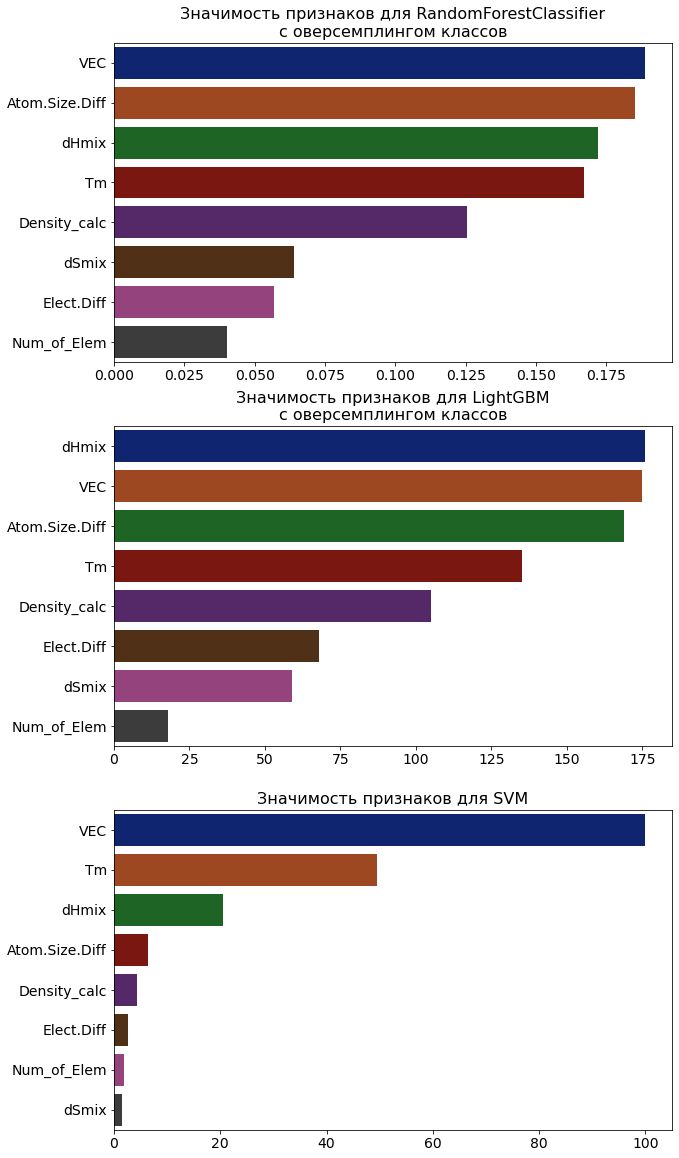

In [35]:
# значимость признаков наиболее результативных вариантов моделей каждого класса
df_temp = df_HEA.copy()
df_temp.drop(columns=['lattice'], inplace=True)

fig, ax = plt.subplots(nrows=3, figsize=(10, 20))

import_feats = pd.Series(rfc_imb_best_model.named_steps['randomforestclassifier'].feature_importances_, 
                         index=df_temp.columns).sort_values(ascending=False)
sns.barplot(x=import_feats, y=import_feats.index, palette='dark', ax=ax[0])
ax[0].set_title('Значимость признаков для RandomForestClassifier\nс оверсемплингом классов')

import_feats = pd.Series(lgbm_imb_best_model.named_steps['lgbmclassifier'].feature_importances_, 
                         index=df_temp.columns).sort_values(ascending=False)
sns.barplot(x=import_feats, y=import_feats.index, palette='dark', ax=ax[1])
ax[1].set_title('Значимость признаков для LightGBM\nс оверсемплингом классов')

svm_coef = abs(svm_best_model.named_steps['svc'].coef_[0])
svm_feat_import = 100.0 * (svm_coef / svm_coef.max())
import_feats = pd.Series(svm_feat_import, index=df_temp.columns).sort_values(ascending=False)
sns.barplot(x=import_feats, y=import_feats.index, palette='dark', ax=ax[2])
ax[2].set_title('Значимость признаков для SVM')

plt.show()

- Среди наиболее значимых признаков в ансамблевых методах RandomForestClassifier и  LGBMClassifier выступают концентрация валентных электронов 'VEC', величина энтальпии смешения 'dHmix' и разница в размерах атомов 'Atom.Size.Diff'. Это хорошо согласуется с экспериментально наблюдаемыми данными.
- В методе SVM наблюдается другое распределение значимости признаков, однако как и для ансамблевых методов признак 'VEC' наиболее важен.

In [36]:
# сохранение лучшей модели (RandomForestClassifier + SMOTE)
dir_path = os.path.join('models', 'rfc_imb_model')
if not os.path.isdir(dir_path):
     os.mkdir(dir_path)
        
cpt_path = os.path.join(dir_path, 'rfc_imb_model.sav')
with open(cpt_path, 'wb') as file:
    joblib.dump(rfc_imb_best_model, file)

## 5. Построение DL моделей

В качестве модели глубокого обучения была выбрана "универсальная" искусственная нейронная сеть в виде многослойной полносвязной нейронной сети (FCNN). Архитектура нейросети: 3 полносвязных скрытых слоя с последовательным уменьшением числа нейронов (1000-500-200) с функцией активации 'elu' и выходной слой из 5 нейронов с функцией активации 'softmax'.

In [37]:
# OneHotEncoding целевого признака
y_train = np_utils.to_categorical(y_train,num_classes=5)
y_test = np_utils.to_categorical(y_test,num_classes=5)

X_test.shape, y_test.shape

((107, 8), (107, 5))

In [38]:
# ограничесние памяти видеоадаптера при использовании архитектуры CUDA
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [39]:
# построение модели полносвязной нейросети
FCNN_model = Sequential()

FCNN_model.add(Dense(1000, input_dim=8, activation='elu'))
FCNN_model.add(Dense(500, activation='elu'))
FCNN_model.add(Dense(200, activation='elu'))

FCNN_model.add(Dense(5, activation='softmax'))

FCNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              9000      
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 200)               100200    
                                                                 
 dense_3 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 610,705
Trainable params: 610,705
Non-trainable params: 0
_________________________________________________________________


In [40]:
# компиляция модели
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()

FCNN_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [41]:
# определение чекпоинтов
cpt_path = os.path.join('models', 'FCNN_model', 'checkpoint_best.h5')

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path,
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                save_best_only=True, 
                                                mode='max')

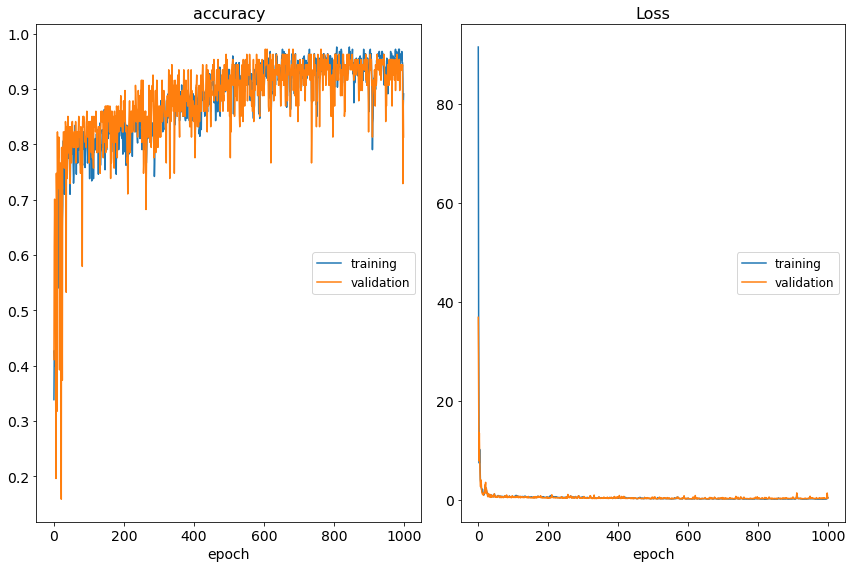

accuracy
	training         	 (min:    0.339, max:    0.976, cur:    0.891)
	validation       	 (min:    0.159, max:    0.972, cur:    0.813)
Loss
	training         	 (min:    0.069, max:   91.430, cur:    0.355)
	validation       	 (min:    0.119, max:   36.812, cur:    0.305)

Epoch 1000: val_accuracy did not improve from 0.97196
13/13 [==============================] - 0s 34ms/step - loss: 0.3551 - accuracy: 0.8911 - val_loss: 0.3047 - val_accuracy: 0.8131


In [42]:
# процесс обучения и сохранения модели
history = FCNN_model.fit(X_train, y_train, 
                         batch_size=20, 
                         epochs=1000,
                         validation_data=(X_test, y_test),
                         callbacks=[PlotLossesCallback(), checkpoint])

In [43]:
# точность и ошибка ИНС
cpt_path = os.path.join('models', 'FCNN_model', 'checkpoint_best.h5')
restored_FCNN_model = tf.keras.models.load_model(cpt_path)
loss, acc = restored_FCNN_model.evaluate(X_test, y_test)
print(f'Точность модели: {acc*100:.2f} %\nВеличина кросс-энтропии: {loss:.4f}')

4/4 [==============================] - 0s 6ms/step - loss: 0.1698 - accuracy: 0.9720
Точность модели: 97.20 %
Величина кросс-энтропии: 0.1698


Точность полносвязной нейросети на тестовой выборке составила 97.2 % , что сравнимо с аналогичной точностью для представленных выше лучших ML моделей (моделей класса RandomForestClassifier). При этом значение кросс-энтропии несколько выше кросс-энтропии указанных ML моделей.

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


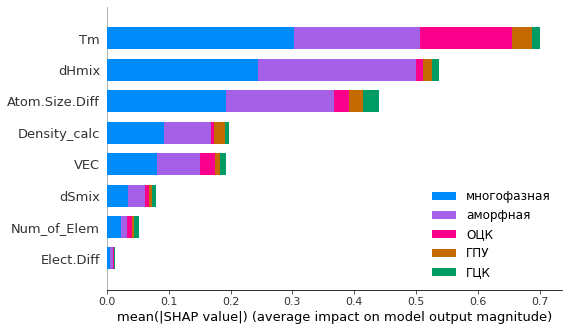

In [44]:
# значимость признаков для ИНС (чувствителен к выборке X_test!!!)
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

explainer = shap.DeepExplainer((restored_FCNN_model.layers[0].input, 
                                restored_FCNN_model.layers[-1].output), background)

shap_values = explainer.shap_values(X_test[:15], check_additivity=False)
shap.summary_plot(shap_values, feature_names=df_HEA.iloc[:, :-1].columns, 
                  class_names=['ОЦК', 'ГЦК', 'ГПУ', 'аморфная', 'многофазная'])

Среди наиболее значимых признаков для нейросети выступают температура плавления 'Tm', разница в размерах атомов 'Atom.Size.Diff' и величина энтальпии смешения 'dHmix'.

## Oбщие выводы работы

- На основе анализа данных были выдвинуты две основные гипотезы, связанных с предсказанием структурно-фазового состава высокоэнтропийных сплавов: 
1.   _Среди таких параметров как плотность 'Density_calc', разница в электроотрицательности 'Elect.Diff' и разница в размерах атомов 'Atom.Size.Diff' наиболее важным является концентрация валентных электронов 'VEC';_
2.   _На склонность к образованию и устойчивость фаз величина энтальпии смешения 'dHmix' влияет сильнее чем энтропийный член 'dSmix'._
- Наилучший результат показал ансамблевый метод RandomForestClassifier с SMOTE оверсемплингом классов с показателями $F_1 = 0.9727$, $NegLogLoss = 0.1649$ и $Accuracy = 0.9720$ на тестовой выборке.
- Точность полносвязной нейросети на тестовой выборке составила 97.2 % , что сравнимо с аналогичной точностью для представленных выше лучших ML моделей (моделей класса RandomForestClassifier).
- Наиболее значимыми признаками в ансамблевых методах (RandomForestClassifier и LGBMClassifier) являются концентрация валентных электронов 'VEC', величина энтальпии смешения 'dHmix' и разница в размерах атомов 'Atom.Size.Diff'. В случае нейросети - признаки 'Tm', 'Atom.Size.Diff' и 'dHmix'.

**По результатам проведенного исследования было решено в качестве "рабочей" модели для развертывания выбрать модель RandomForestClassifier с SMOTE оверсемплингом классов.**
<br>[Ссылка на развернутый проект](https://high-entropy-alloy-phase-prediction.onrender.com/)